<H1>Scraping Bachelor Wikipedia Episode Tables and Reddit Data for Viewer Prediction</H1>
pyBach is a collection of functions that allows for scraping of bachelor and bachelorette data from Wikipedia and Reddit

In [1]:
#Using https://www.tensorflow.org/tutorials/keras/basic_regression as template NN-regression analysis
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pyBach #my module

<ul>
<li>First scrape last 5 season of The Bachelor and The Bachelorette into a pandas dataframe</li>
    <li>Join all individual dataframes into one large dataframe</li>
    <li>Reset the dataframe index</li>

In [2]:
dfList = []
bachSeasons = range(19,24)
etteSeasons = range(10,15)

for bachSeason in bachSeasons:
    dfList.append(pyBach.scrapeWikiEpiTable(bachSeason))
for etteSeason in etteSeasons:
    dfList.append(pyBach.scrapeWikiEpiTable(etteSeason, show='bachelorette'))

df = pd.concat(dfList)
df.reset_index()

,index,numOverall,numInSeason,year,month,day,posix time,isBachelor,season,viewers(millions)
0,0,182.0,1.0,2015,1,5,1420434000,1.0,19,7.76
1,1,183.0,2.0,2015,1,12,1421038800,1.0,19,6.48
2,2,184.0,3.0,2015,1,19,1421643600,1.0,19,7.61
3,3,185.0,4.0,2015,1,26,1422248400,1.0,19,7.95
4,4,186.0,5.0,2015,2,2,1422853200,1.0,19,8.45
5,5,187.0,6.0,2015,2,9,1423458000,1.0,19,8.70
6,6,188.0,7.0,2015,2,15,1423976400,1.0,19,6.05
7,7,189.0,8.0,2015,2,16,1424062800,1.0,19,8.97
8,8,190.0,9.0,2015,2,23,1424667600,1.0,19,8.97
9,9,191.0,10.0,2015,3,2,1425272400,1.0,19,8.15


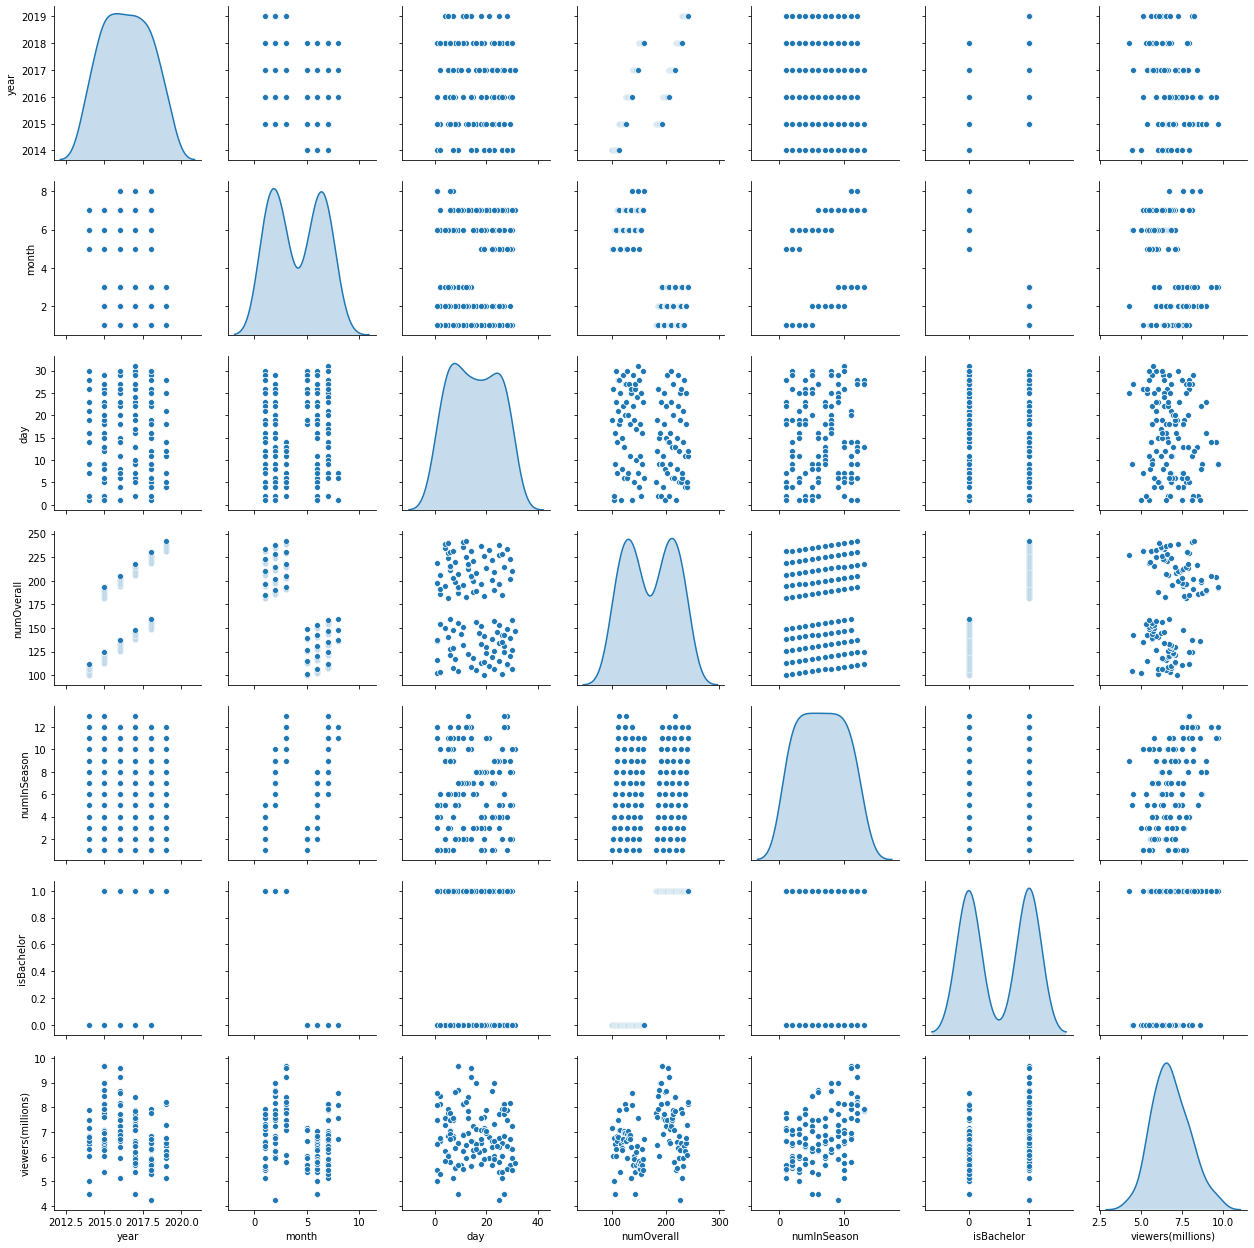

In [22]:
sns.pairplot(df[["year", "month", "day", "numOverall", "numInSeason", "isBachelor", "viewers(millions)"]], diag_kind="kde")

## Scrape all submission titles and all comments from the week leading up to the episode
This part of the module performs two tasks
<ol>
    <li>Counts the total number of submisisons(AKA posts) and total number of comments in the 'TheBachelor' subreddit the week before the episode airs<\li>
        <li>Performs VADER (Valence Aware Dictionary and sEntiment Reasoner) analysis on each submission title and comment text. The individual text gets a single compound score, with -1 being most negative, and 1 being most positive.

In [30]:
#dfTotal = pyBach.appendRedditStats(df)
dfTotal = pd.read_pickle('dfTotal.pickle')

In [31]:
dfTotal.head()

,numOverall,numInSeason,year,month,day,posix time,isBachelor,season,viewers(millions),endEpoch,startEpoch,subNum,commentNum,meanTitleSentiment,stdTitleSentiment,meanCommentSentiment,stdCommentSentiment
0,182.0,1.0,2015,1,5,1420434000,1.0,19,7.76,1420452000,1419933600,0,0,-2.000000,0.000000,-2.000000,0.000000
1,183.0,2.0,2015,1,12,1421038800,1.0,19,6.48,1421056800,1420538400,5,32,0.029320,0.377958,0.546000,0.383221
2,184.0,3.0,2015,1,19,1421643600,1.0,19,7.61,1421661600,1421143200,4,26,0.365925,0.372033,0.092185,0.494706
3,185.0,4.0,2015,1,26,1422248400,1.0,19,7.95,1422266400,1421748000,10,46,0.002340,0.402318,0.133093,0.495796
4,186.0,5.0,2015,2,2,1422853200,1.0,19,8.45,1422871200,1422352800,4,18,0.000000,0.000000,0.241617,0.516518


C:\Users\ayush\Anaconda\envs\praw\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\ayush\Anaconda\envs\praw\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


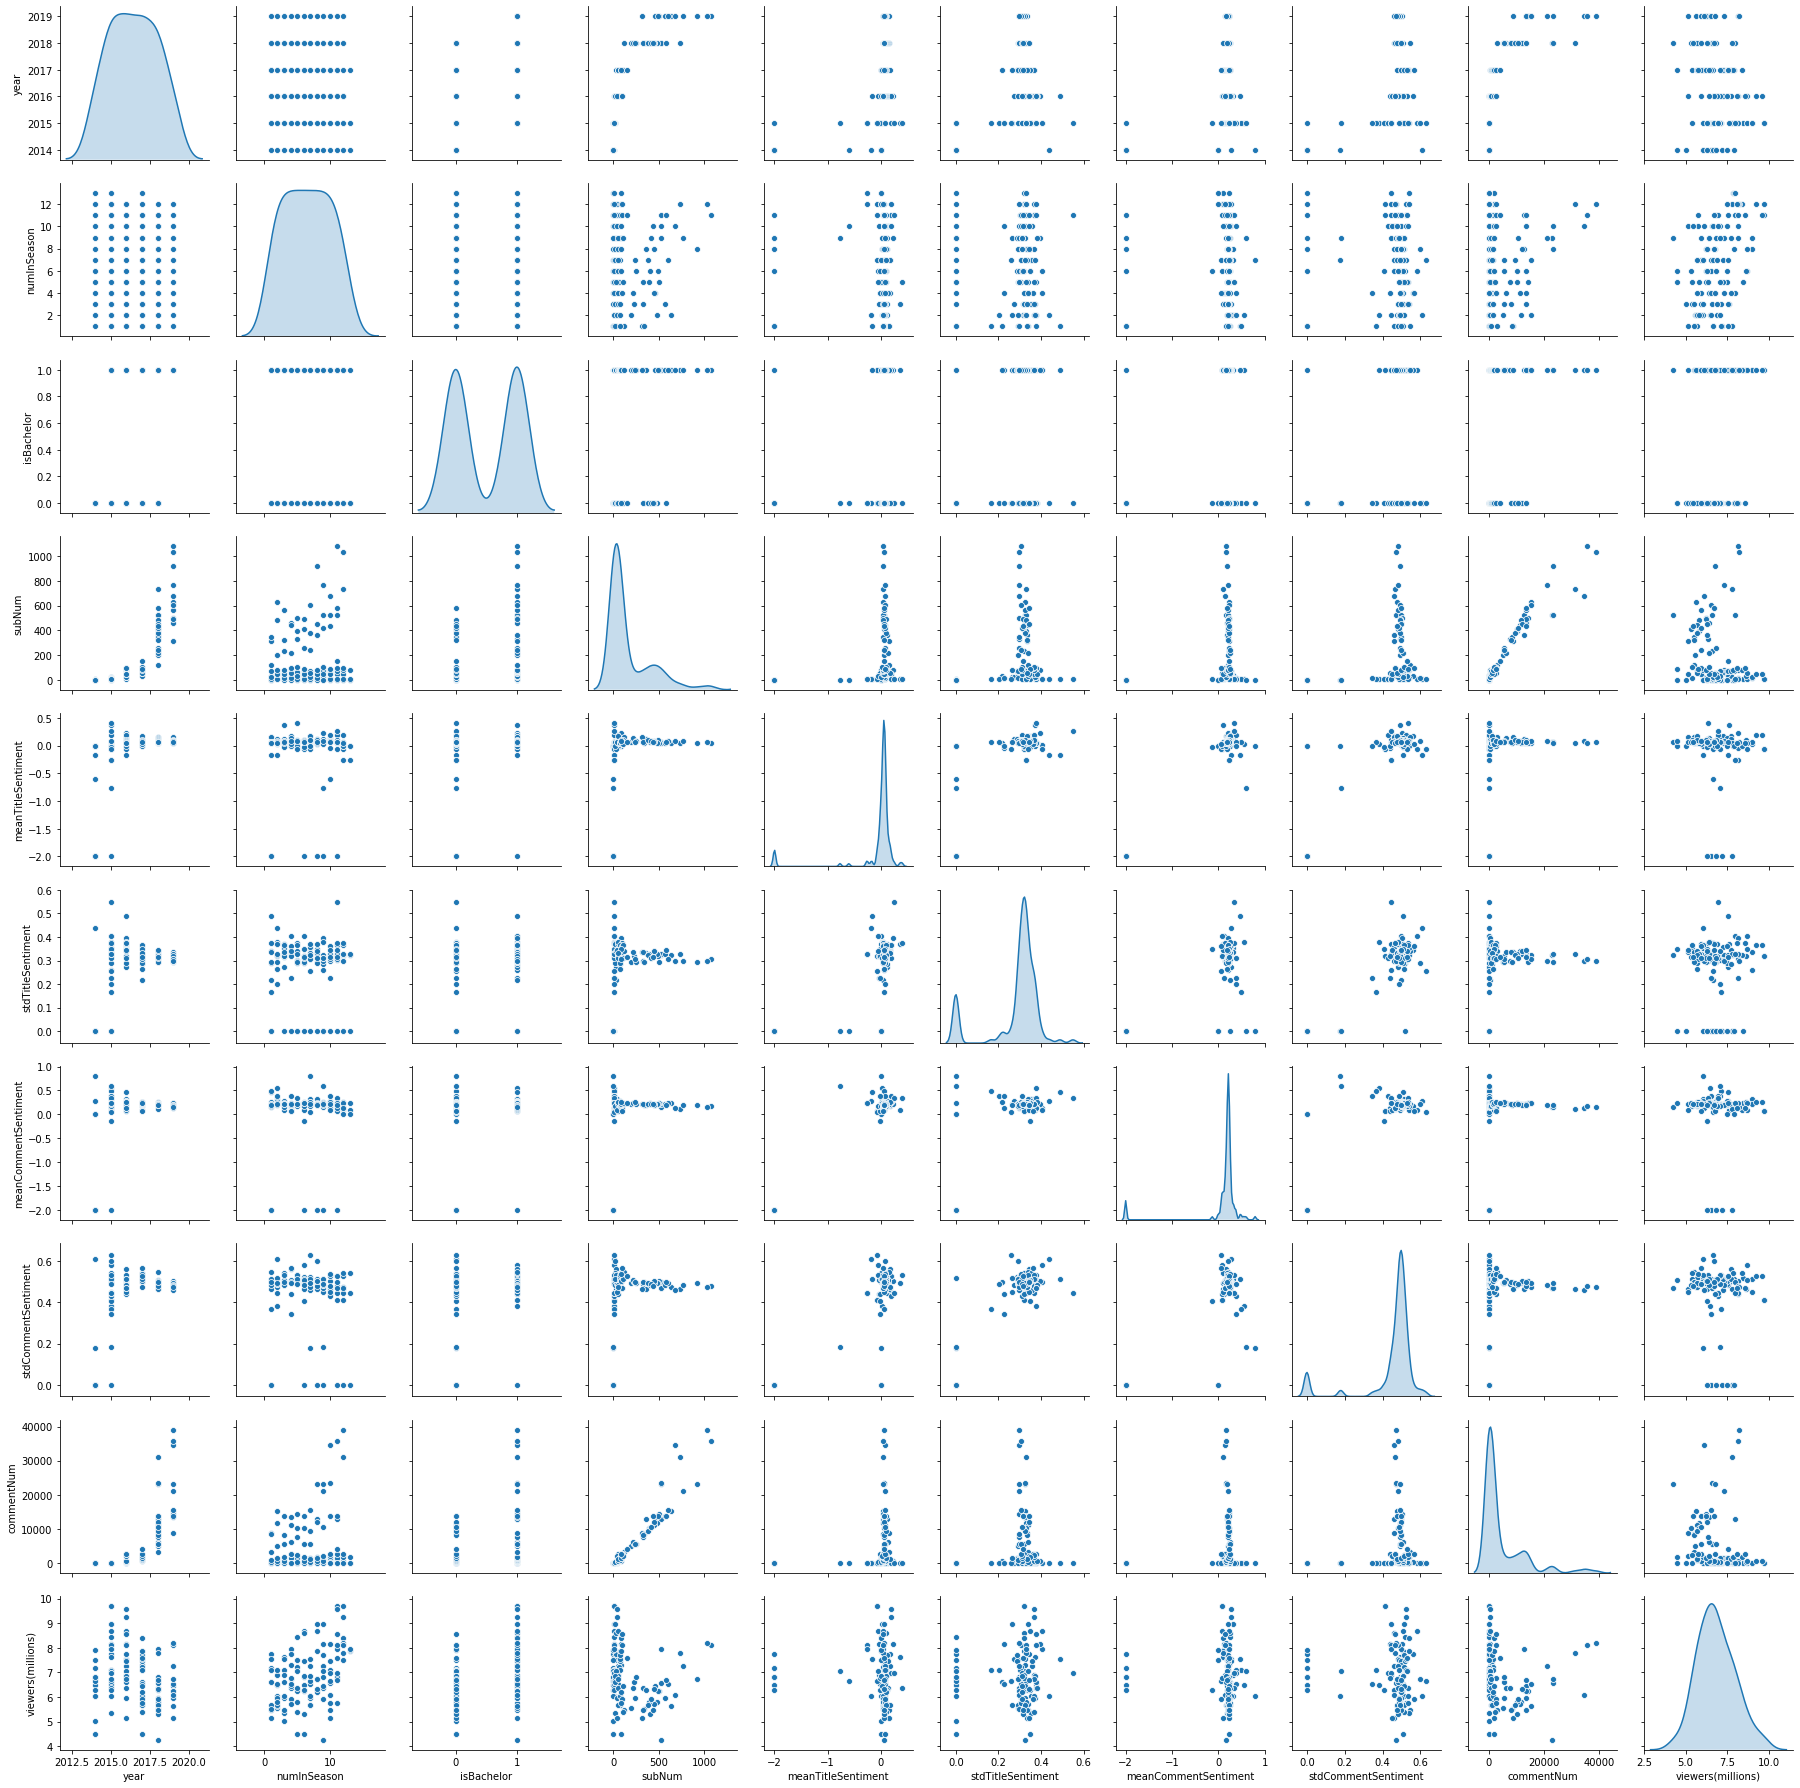

In [35]:
sns.pairplot(dfTotal[["year","numInSeason", "isBachelor", "subNum", "meanTitleSentiment", "stdTitleSentiment", "meanCommentSentiment", "stdCommentSentiment", "commentNum", "viewers(millions)"]], diag_kind="kde")